In [1]:
import pandas as pd
import numpy as np
import datetime
!pip install pandasql
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [2]:
# data reading
df=pd.read_excel(r'/Users/zjy/Documents/Factor Model Template.xlsx', skiprows=lambda x: x in [0, 3] , header=3, sheet_name=None, na_values=['#VALUE!','NM',0,'#DIV/0!'])
df_=pd.read_csv(r'/Users/zjy/Downloads/SPY.csv')

In [3]:
# define some variables
quarters = list(df.keys())
factors = df[quarters[0]].columns

#lower-better factors
asc_list = ['TEV/Revenue','TEV/EBITDA','TEV/EBIT','P/S','P/E','P/B','Debt/EBITDA','Debt/Equity','Debt/Capital']

# divide the metric header by factor
value_fac = ['TEV/Revenue','TEV/EBITDA','TEV/EBIT','P/S','P/E','P/B']
growth_fac = ['Revenue G%','GP G%','EBITDA G%','EBIT G%','NI G%','EPS G%']
profitability_fac = ['Gross M%','EBITDA M%','EBIT M%','NI M%','UFCF M%','LFCF M%']
solvency_fac = ['Debt/EBITDA','Debt/Equity','Debt/Capital']
dividend_fac = ['Dividend Y%','Dividend G%','Dividend P%']
momentum_fac = ['1M Return%','3M Return%','6M Return%']  

In [4]:
# data cleaning
# delete first coln (empty)
for key in df:
    sheet = df[key]
    sheet.drop(sheet.columns[[0]], axis=1, inplace=True) 

# after setting nan values, we assign them with a large/small enough number s.t. they don't get selected
for factor in factors[7:]: #for each column after TEV
    for quarter in quarters[:20]: #for each quarter
        if factor in asc_list:
            df[quarter][factor].fillna(df[quarter][factor].max(),inplace=True)
        else:
            df[quarter][factor].fillna(df[quarter][factor].min(),inplace=True)

In [5]:
###################################### functions for S&P 500 ######################################
def get_quarter(date):
    return (date.month - 1) / 3 + 1

def get_first_day_of_the_quarter(date):
    quarter = get_quarter(date)
    return datetime.datetime(date.year, 3 * quarter - 2, 1)

def get_last_day_of_the_quarter(date):
    quarter = get_quarter(date)
    month = 3 * quarter
    remaining = month / 12
    return datetime.datetime(date.year + remaining, month % 12 + 1, 1) + datetime.timedelta(days=-1)

def find_closest_start_date(df, start_date): #find closest date in "date_list" to "date"
    target_dates = pd.to_datetime(df['Date'][df['Date']>=start_date.strftime("%Y-%m-%d")])
    nearest_date = min(target_dates, key=lambda x: abs(x - start_date))
    return (nearest_date)

def find_closest_end_date(df, end_date): #find closest date in "date_list" to "date"
    target_dates = pd.to_datetime(df['Date'][df['Date']<=end_date.strftime("%Y-%m-%d")])
    nearest_date = min(target_dates, key=lambda x: abs(x - end_date))
    return (nearest_date)

In [6]:
# cumulative return of S&P 500
from datetime import date
from calendar import monthrange
from datetime import datetime

In [7]:
SP_500_cumu_ret = []
SP_500_q_ret = []

head_quarter = int(quarters[0][1])
head_year = int(quarters[0][3:7])
head_month = 3 * head_quarter - 2
head_day = date(head_year, head_month, 1)
head_date = find_closest_start_date(df_, pd.Timestamp(head_day))
head_date_close = df_['Adj Close'][df_['Date']==head_date.strftime("%Y-%m-%d")]

for q in quarters[:20]:
    
    start_quarter = int(q[1])
    start_year = int(q[3:7])
    first_month = 3 * start_quarter - 2
    first_day = date(start_year, first_month, 1)
    start_date = find_closest_start_date(df_, pd.Timestamp(first_day))
    start_date_close = df_['Adj Close'][df_['Date']==start_date.strftime("%Y-%m-%d")]
    
    end_quarter = int(q[1])
    year = int(q[3:7])
    last_month = 3 * end_quarter 
    last_day = date(year, last_month, monthrange(year, last_month)[1])
    
    ###if no data for 'Adj Close' at this date, find the closest date
    end_date = find_closest_end_date(df_, pd.Timestamp(last_day))
    end_date_close = df_['Adj Close'][df_['Date']==end_date.strftime("%Y-%m-%d")]
    
    SP_500_q_return = float(end_date_close)/float(start_date_close) - 1
    SP_500_cumu_return = float(end_date_close)/float(head_date_close) - 1
    SP_500_q_ret.append(SP_500_q_return*100)
    SP_500_cumu_ret.append(SP_500_cumu_return*100)
    

In [8]:
# S&P 500 cumulative return
SP_500_cumu_ret

[6.303117609046671,
 5.245088479546789,
 8.983789123971775,
 17.322342603904552,
 1.4461486469342422,
 15.167798724754356,
 20.03780281145724,
 22.143764916870424,
 33.12153854376256,
 7.232476385389575,
 28.85242640560717,
 40.498547519932806,
 57.524872472735986,
 67.5305247553242,
 81.53490038864169,
 82.57597979646386,
 102.77983166239193,
 93.42261182962824,
 62.26171849905175,
 54.26034424398427]

In [9]:
# S&P quarter return
SP_500_q_ret

[6.303117609046671,
 -1.6988667759204934,
 5.836822483901094,
 7.421452075336976,
 -13.831484901415948,
 13.408081489241397,
 3.0070480955732837,
 0.8389465333174861,
 10.299552641071784,
 -20.194031484004082,
 25.824468895263863,
 8.279841645596608,
 11.40329484285012,
 7.819637025022574,
 7.201620302102296,
 0.01971160114948578,
 9.761577710226565,
 -5.163574394678861,
 -16.347346454649013,
 -5.926126096266948]

In [10]:
#S&P 500 5yr return
SP_500_5yr_ret=SP_500_cumu_ret[19]
SP_500_5yr_ret

54.26034424398427

In [11]:
###################################### functions for factor data ######################################

def get_top10(df, metric, quarter, asc_list): #get top10 of a factor
    
    if factor in asc_list: # if in "lower-better", rank ascendingly
        top10=df[quarter].nsmallest(10, metric)
            
    else: # if in "higher-better", rank descendingly
        top10=df[quarter].nlargest(10, metric)
        
    return top10

#if take 3m return from the next quarter
def get_3m_ret(df, quarter, top10): #get quarter return of given companies
    tickers=list(top10['Ticker'])
    companies=df[quarter].loc[df[quarter]['Ticker'].str.contains(tickers[0], case=False)]
    for ticker in tickers[1:]:
        temp_company=df[quarter].loc[df[quarter]['Ticker'].str.contains(ticker, case=False)]
        companies=pd.concat([companies, temp_company])
        
    _3m_ret=[x for x in companies['3M Return%'] if not(pd.isnull(x)) == True]
    avg_3m_ret=sum(_3m_ret)/len(_3m_ret)

    return avg_3m_ret

# if take 3m return from the same quarter
def get_avg_q_return(df, top10):
    _3m_ret = top10['3M Return%']
    print(_3m_ret)
    print(sum(_3m_return))
    avg_3m_ret = sum(_3m_ret)/len(_3m_ret)
    
    return avg_3m_ret
def get_5yr_ret(avg_3m_ret):
    #total return = (1+1stQ_return)*(1+2ndQ_return)...*(1+20thQ_return)-1
    
    total_rt = 1+avg_3m_ret[0]
    for i in range(1,len(avg_3m_ret)):
        #print(total_rt)
        total_rt = (1+avg_3m_ret[i])*total_rt
    total_rt = (total_rt) - 1
    return total_rt
        
#select variable and build the porfolio
def variable_select(_5yr_ret,value_fac,growth_fac,profitability_fac,solvency_fac,dividend_fac,momentum_fac):
    value_max=-1
    growth_max=-1
    profitability_max=-1
    solvency_max=-1
    dividend_max=-1
    momentum_max=-1
    selected_var = {}
    for key in _5yr_ret:
        if key in value_fac and _5yr_ret[key]>value_max:
            value_max=_5yr_ret[key]
            value_factor=key
            
        elif key in growth_fac and _5yr_ret[key]>growth_max:
            growth_max=_5yr_ret[key]
            growth_factor=key
            
        elif key in profitability_fac and _5yr_ret[key]>profitability_max:
            profitability_max=_5yr_ret[key]
            profitability_factor=key
            
        elif key in solvency_fac and _5yr_ret[key]>solvency_max:
            solvency_max=_5yr_ret[key]
            solvency_factor=key
        
        elif key in dividend_fac and _5yr_ret[key]>dividend_max:
            dividend_max=_5yr_ret[key]
            dividend_factor=key
        
        elif key in momentum_fac and _5yr_ret[key]>momentum_max:
            momentum_max=_5yr_ret[key] 
            momentum_factor=key
        else:
            pass
    
    selected_var[value_factor]=value_max
    selected_var[growth_factor]=growth_max
    selected_var[profitability_factor]=profitability_max
    selected_var[solvency_factor]=solvency_max
    selected_var[dividend_factor]=dividend_max
    selected_var[momentum_factor]=momentum_max

    return selected_var
        
def get_rank(df, variables, quarter, asc_list):
    #returns the companies that has smallest sum of rank wrpt selected variables
    for variable in variables:
        #rank compenies based on the porfolio
        new_col = variable + 'rank'
        if variable in asc_list:
            df[quarter][new_col] = df[quarter][variable].rank(ascending=True)
        else:
            df[quarter][new_col] = df[quarter][variable].rank(ascending=False)
            
    #sum the rank
    df[quarter]['Sum Rank']=df[quarter].iloc[:,36:41].sum(axis=1)
    top10 = df[quarter].nsmallest(10, 'Sum Rank')
    return top10

In [12]:
# overview the data
df['Q4 2017'].head() 

,Ticker,Company,Sector,Industry,Market Cap,TEV,TEV/Revenue,TEV/EBITDA,TEV/EBIT,P/S,...,ROC%,Debt/EBITDA,Debt/Equity,Debt/Capital,Dividend Y%,Dividend G%,Dividend P%,1M Return%,3M Return%,6M Return%
0,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage and Peripherals",860882.48688,707667.48688,3.08710,9.89731,11.53605,3.85158,...,0.166346,1.05448,0.873044,0.466109,0.014890,0.265875,0.256862,-0.010640,0.100254,0.179303
1,MSFT,Microsoft Corporation,Information Technology,Systems Software,659906.04528,622266.04528,6.72284,18.48681,26.33930,7.13981,...,0.124531,2.15626,1.278343,0.561084,0.019639,0.135019,0.886687,0.015191,0.146495,0.254804
2,GOOG,Alphabet Inc.,Communication Services,Interactive Media and Services,729458.18968,633279.18968,6.05453,18.38736,22.73322,26.40543,...,0.120699,0.10239,0.026025,0.025365,0.000196,-0.315745,0.001100,0.035865,0.097695,0.164349
3,GOOGL,Alphabet Inc.,Communication Services,Interactive Media and Services,729458.18968,633279.18968,6.05453,18.38736,22.73322,6.96624,...,0.120699,0.10239,0.026025,0.025365,0.000196,-0.315745,0.001100,0.027637,0.088819,0.145672
4,AMZN,"Amazon.com, Inc.",Consumer Discretionary,Internet and Direct Marketing Retail,563535.05250,582411.05250,3.61400,45.05733,180.53659,3.47240,...,0.046025,1.82295,1.591829,0.614172,0.000196,-0.315745,0.001100,0.006126,0.219227,0.226297


In [13]:
# know the component of this data set
df['Q1 2018'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 36 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ticker        406 non-null    object 
 1   Company       406 non-null    object 
 2   Sector        406 non-null    object 
 3   Industry      406 non-null    object 
 4   Market Cap    394 non-null    float64
 5   TEV           394 non-null    float64
 6   TEV/Revenue   406 non-null    float64
 7   TEV/EBITDA    406 non-null    float64
 8   TEV/EBIT      406 non-null    float64
 9   P/S           406 non-null    float64
 10  P/E           406 non-null    float64
 11  P/B           406 non-null    float64
 12  Revenue G%    406 non-null    float64
 13  GP G%         406 non-null    float64
 14  EBITDA G%     406 non-null    float64
 15  EBIT G%       406 non-null    float64
 16  NI G%         406 non-null    float64
 17  EPS G%        406 non-null    float64
 18  Gross M%      406 non-null    

In [14]:
_5yr_ret={}
variables={}
for factor in factors[7:]: #for each column after TEV
    avg_3m_ret=[]
    for quarter in quarters[:19]: #for each quarter
        top10 = get_top10(df, factor, quarter, asc_list) #get a dataframe
        next_qt = quarters[quarters.index(quarter) + 1]
        _3m_ret = get_3m_ret(df, next_qt, top10) #average quarter return for
        avg_3m_ret.append(_3m_ret)
    _5yr_ret[factor]=get_5yr_ret(avg_3m_ret)
_5yr_ret

{'TEV/Revenue': 1.1180681457066122,
 'TEV/EBITDA': 0.4786381804775621,
 'TEV/EBIT': 0.39163591662614716,
 'P/S': 0.7944360478167933,
 'P/E': 0.07224193315405736,
 'P/B': 0.6109093402149477,
 'Revenue G%': 1.5161629687685338,
 'GP G%': 2.6726540324016708,
 'EBITDA G%': 2.24474820841248,
 'EBIT G%': 0.8823442337716774,
 'NI G%': 0.7845936593487914,
 'EPS G%': 0.48416173855215594,
 'Gross M%': 0.4160613799759749,
 'EBITDA M%': 0.36504802827457383,
 'EBIT M%': 0.3352261101024694,
 'NI M%': 0.3339801412728496,
 'UFCF M%': 0.11536281985571528,
 'LFCF M%': 0.1783958707890081,
 'ROA%': 0.23263978684757602,
 'ROE%': 0.4579930283686977,
 'ROC%': 0.18291089337077593,
 'Debt/EBITDA': 0.8304185951737091,
 'Debt/Equity': 0.27815157540248237,
 'Debt/Capital': 0.27815157540248237,
 'Dividend Y%': 1.0861600362169868,
 'Dividend G%': 0.627830804911657,
 'Dividend P%': 0.37126278194955953,
 '1M Return%': 0.2675178130831919,
 '3M Return%': 1.1397210880085593,
 '6M Return%': 3.923640642880809}

In [15]:
#select the metrics with highest return
variables=variable_select(_5yr_ret,value_fac,growth_fac,profitability_fac,solvency_fac,dividend_fac,momentum_fac)
variables

{'TEV/Revenue': 1.1180681457066122,
 'GP G%': 2.6726540324016708,
 'Gross M%': 0.4160613799759749,
 'Debt/EBITDA': 0.8304185951737091,
 'Dividend Y%': 1.0861600362169868,
 '6M Return%': 3.923640642880809}

In [16]:
# only keep those outperform the S&P 500
portfolio = {}
for var in variables:
    if variables[var]*100 > SP_500_5yr_ret:
        portfolio[var] = variables[var]*100
portfolio

{'TEV/Revenue': 111.80681457066122,
 'GP G%': 267.2654032401671,
 'Debt/EBITDA': 83.04185951737091,
 'Dividend Y%': 108.61600362169868,
 '6M Return%': 392.3640642880809}

In [17]:
# repeat previous steps....
top10_3m_ret=[]
top10_cumu_ret = []

quarter_top10=[]
new_top10 = get_rank(df, portfolio, 'Q4 2017', asc_list)
_3m_ret = get_3m_ret(df, quarter, new_top10)
top10_3m_ret.append(_3m_ret)
top10_cumu_ret.append(get_5yr_ret(top10_3m_ret))

quarter_top10.append('Q4 2017')
quarter_top10 = quarter_top10 + list(new_top10['Ticker'])   
companies = pd.DataFrame(quarter_top10)
    
for quarter in quarters[1:20]: 
    quarter_top10=[]
    # find top10 with lowest average rank
    new_top10 = get_rank(df, portfolio, quarter, asc_list)
    
    _3m_ret = get_3m_ret(df, quarter, new_top10)
    top10_3m_ret.append(_3m_ret)
    top10_cumu_ret.append(get_5yr_ret(top10_3m_ret))
    
    # keep top10 in record
    quarter_top10.append(quarter)
    quarter_top10 = quarter_top10 + list(new_top10['Ticker'])   
    d = pd.DataFrame(quarter_top10)
    companies=pd.concat([companies, d],axis=1)
    #print(quarter_top10)
_3m_ret

0.02356064735257383

In [18]:
companies.columns = companies.iloc[0] 
companies=companies.drop(index=companies.index[0], axis=1)
companies

,Q4 2017,Q1 2018,Q2 2018,Q3 2018,Q4 2018,Q1 2019,Q2 2019,Q3 2019,Q4 2019,Q1 2020,Q2 2020,Q3 2020,Q4 2020,Q1 2021,Q2 2021,Q3 2021,Q4 2021,Q1 2022,Q2 2022,Q3 2022
1,TSCO,NUE,MOH,DRI,CMI,DRI,CMI,DHI,MPC,ABC,ABC,DHI,PWR,NUE,NUE,NUE,DVN,PXD,VLO,VLO
2,BA,BBY,TJX,TSCO,MOH,LRCX,LRCX,LMT,JBHT,CAH,DHI,PHM,NUE,EOG,DHI,NRG,NUE,NUE,PXD,COP
3,TSN,BA,NUE,MOH,NUE,CMI,LMT,ALK,DHI,UNH,UNH,PWR,DHI,HPQ,EOG,DVN,COP,DVN,XOM,XOM
4,DHI,DAL,RHI,NUE,TSCO,NUE,TSN,PHM,BBY,MOH,KR,BBY,HPQ,PWR,LEN,COP,PXD,COP,DVN,MPC
5,PHM,RHI,MU,TJX,WBA,TSN,DHI,TGT,UNH,BBY,MOH,LEN,PARA,PARA,COP,EXPD,MOS,XOM,COP,DVN
6,LRCX,ROST,DRI,ALK,AVGO,DLTR,BBY,COST,CVS,CVS,TSCO,TRGP,LEN,GRMN,EXPD,COST,HPQ,EOG,CTRA,CTRA
7,LYB,MU,TSCO,COST,FAST,GRMN,NUE,LRCX,WRK,CI,LMT,PARA,PHM,CI,HPQ,PXD,CF,HPQ,FANG,PXD
8,ROST,WRK,VLO,TRGP,DRI,AMAT,AMAT,CVS,LRCX,COST,CAH,GPC,TGT,ELV,PHM,EOG,DHI,NRG,EOG,LEN
9,MU,DHI,LRCX,RHI,LRCX,PWR,DRI,NVR,VLO,HPQ,CNC,LOW,WHR,DHI,MOS,MOS,LEN,CVX,CVX,FANG
10,VLO,TJX,BA,EXPE,HRL,DG,COST,CMI,NWL,LMT,HUM,JCI,DVN,HII,TGT,TGT,COST,MOS,NUE,EXPD


In [19]:
# portfolio quarter return
portfolio_q_ret=[i * 100 for i in top10_3m_ret]
portfolio_q_ret

[-15.119530858613953,
 1.8676398474340563,
 5.948938748056495,
 14.794594230616854,
 -8.035516831884468,
 20.630813917427425,
 5.34183664578412,
 11.60101187744578,
 18.118466377648208,
 -13.377048627492751,
 30.15039361696285,
 22.03503686850462,
 16.928806322099774,
 23.44537332318776,
 7.404195011680425,
 3.56714593641815,
 17.765189831965483,
 30.308213080108597,
 -9.071817344531233,
 2.356064735257383]

In [20]:
# portfolio cumulative return
portfolio_cumu_ret = [i * 100 for i in top10_cumu_ret]
portfolio_cumu_ret

[-15.119530858613949,
 -13.53426939424046,
 -8.390476042444295,
 5.162781303675823,
 -3.287591688858904,
 16.664965304875224,
 22.897017174322375,
 37.15431473374209,
 62.004573134268945,
 40.33314260733574,
 82.64413747850128,
 122.88984051005131,
 160.62242992163496,
 221.72633158072568,
 245.54757657488815,
 257.8737629110707,
 321.4507162510205,
 449.1848973600236,
 399.363846587771,
 411.12918207785015]

In [21]:
# 5-year return of the portfolio
_5yr_ret=get_5yr_ret(top10_3m_ret)
_5yr_ret*100

411.12918207785015

In [22]:
# fit linear model
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import linregress
import seaborn as sns

In [27]:
# excessive return of portfolio
excessive_return_dict = {}
excessive_return_list = []

for var in portfolio:                     
    excessive_return_dict[var] = (portfolio[var] - SP_500_5yr_ret)
    excessive_return_list.append(portfolio[var] - SP_500_5yr_ret)
    
excessive_return_dict

{'TEV/Revenue': 57.546470326676946,
 'GP G%': 213.0050589961828,
 'Debt/EBITDA': 28.78151527338664,
 'Dividend Y%': 54.35565937771441,
 '6M Return%': 338.10372004409663}

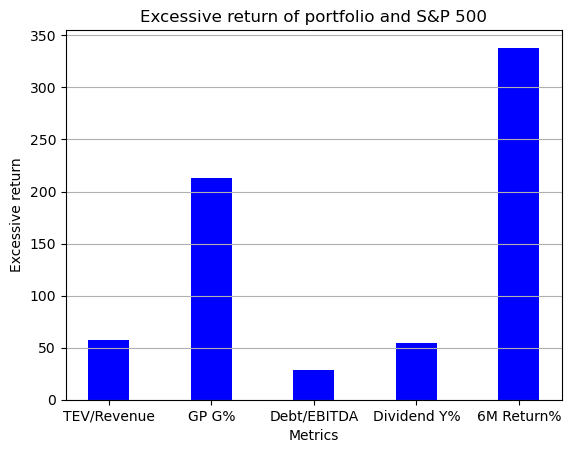

In [28]:
# bar chart of excessive return

X = list(portfolio.keys())
width = 0.4

fig, ax = plt.subplots()
ax.bar(X, excessive_return_list, width, color='blue')

plt.ylabel("Excessive return")
plt.xlabel("Metrics")
plt.grid(axis = 'y')
plt.title("Excessive return of portfolio and S&P 500")

plt.show()

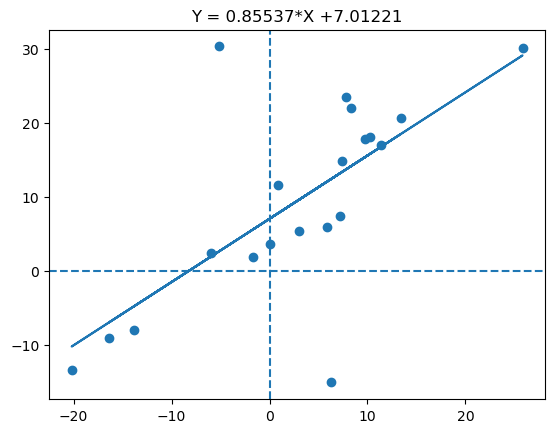

R-square:0.473635
beta:0.855370


In [29]:
#regression on s&P 500 cumulative return and portfolio cumulative return

y = portfolio_q_ret #independent variable
x = SP_500_q_ret #dependent variable

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))
#fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.axhline(0, linestyle = '--')
plt.axvline(0, linestyle = '--')

plt_title = "Y = " + str(round(slope,5)) + "*X +" + str(round(intercept,5))
plt.title(plt_title)
plt.show()

print("R-square:%f"%(r*r))
print("beta:%f"%(slope))

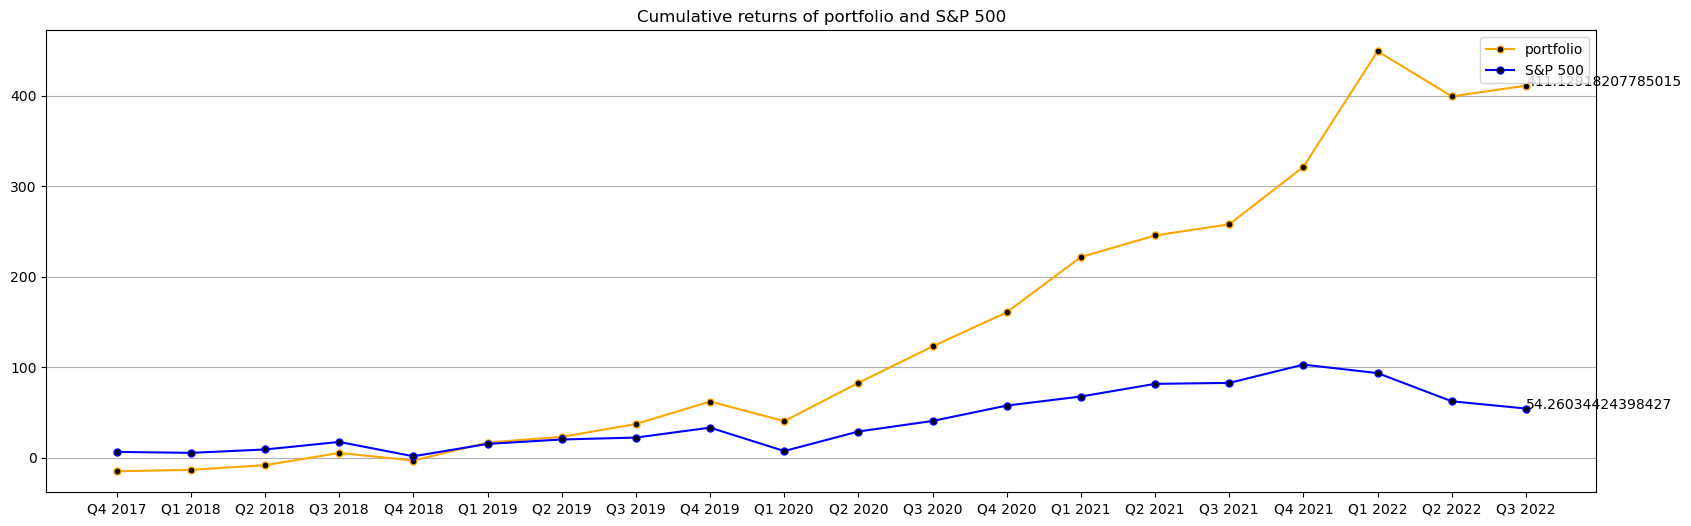

In [30]:
#line plot of cumulative return of S&P 500 and portfolio
X = quarters[:20]
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(X, (portfolio_cumu_ret), label = "portfolio", color = 'orange', marker = 'o',
         markerfacecolor = 'black', markersize = 5)
plt.plot(X, (SP_500_cumu_ret), label = "S&P 500", color = 'blue', marker = 'o',
         markerfacecolor = 'black', markersize = 5)
ax.text('Q3 2022', portfolio_cumu_ret[-1], str(portfolio_cumu_ret[-1]))
ax.text('Q3 2022', SP_500_cumu_ret[-1], str(SP_500_cumu_ret[-1]))

plt.title("Cumulative returns of portfolio and S&P 500")
plt.grid(axis = 'y')
plt.legend()
plt.show()

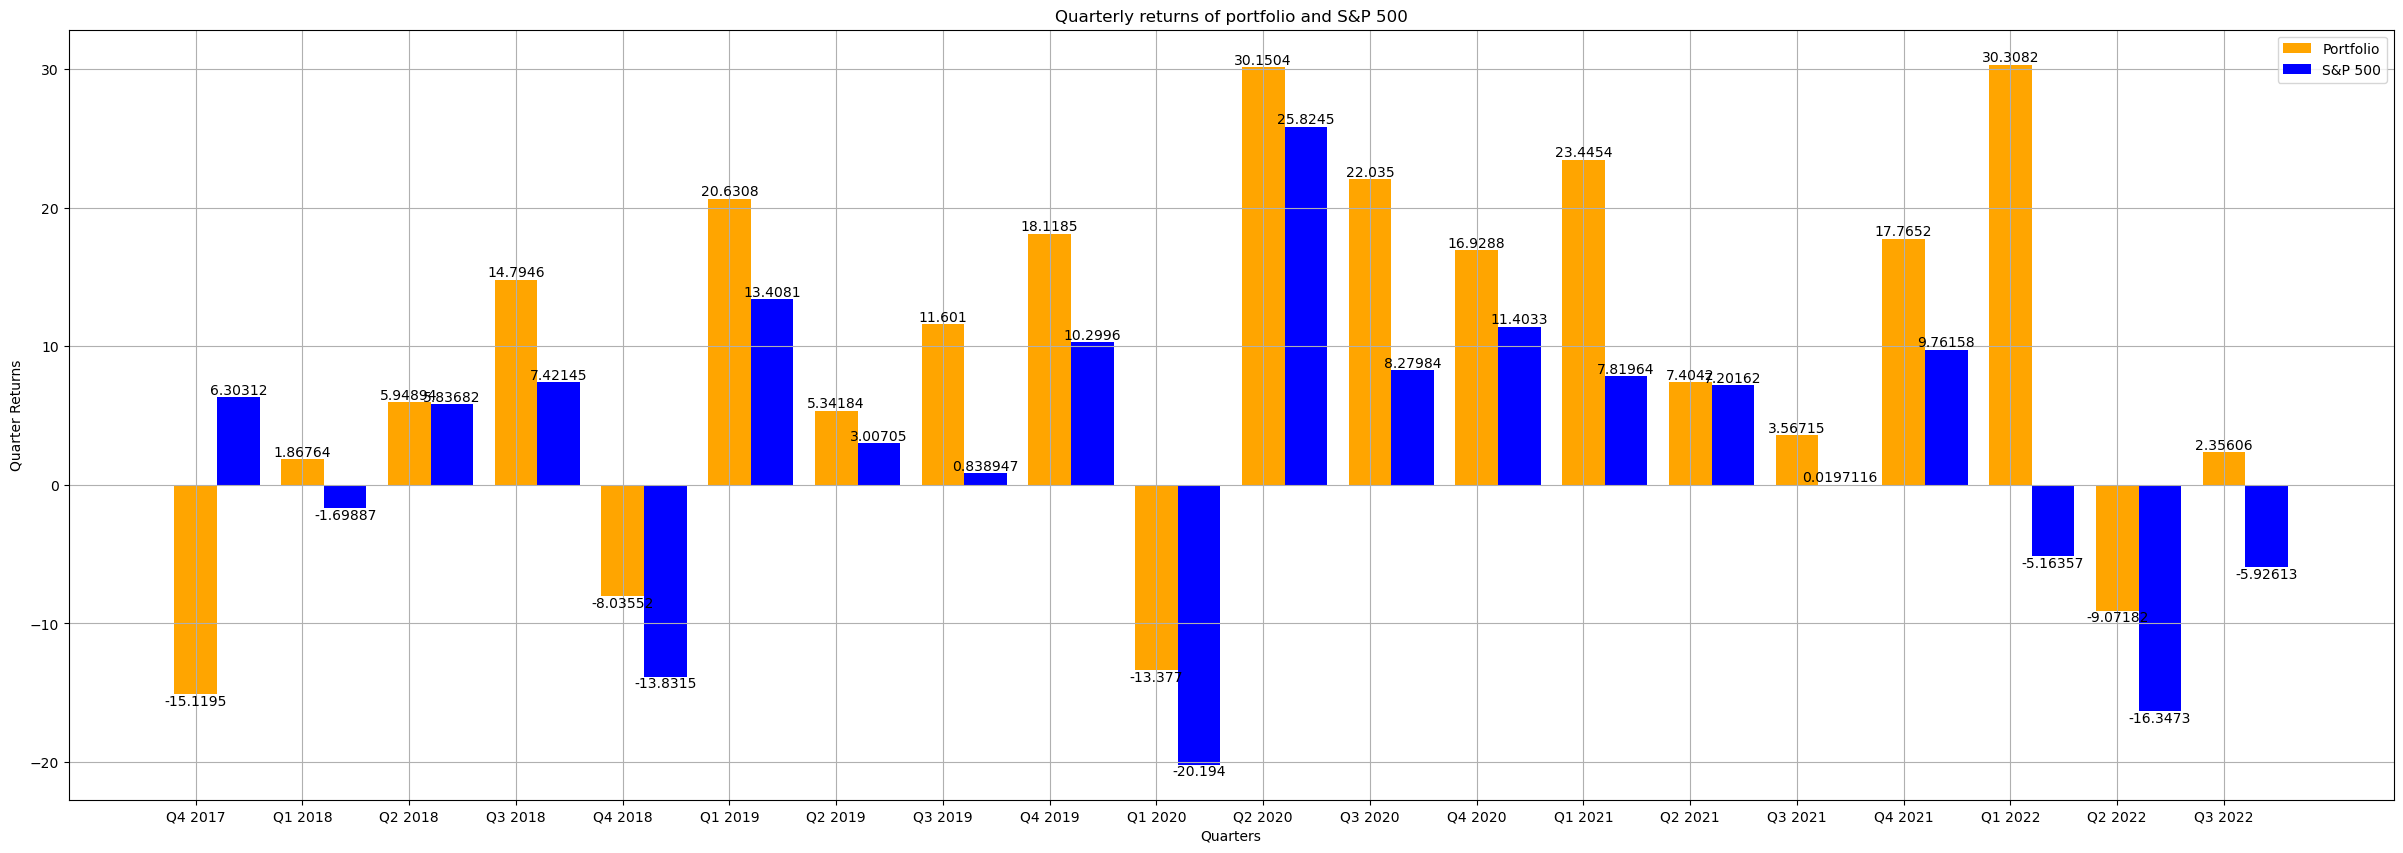

In [31]:
X = quarters[:20]
X_axis = np.arange(len(X))
width = 0.4

fig, ax = plt.subplots(figsize=(30,10))
plt.bar(X_axis, portfolio_q_ret, width, color='orange', label='Portfolio')
plt.bar(X_axis + width, SP_500_q_ret, width, color='blue', label='S&P 500')

plt.xticks(X_axis, X)
plt.ylabel("Quarter Returns")
plt.xlabel("Quarters")
plt.title("Quarterly returns of portfolio and S&P 500")
plt.grid(which='both')
for container in ax.containers:
    ax.bar_label(container)
plt.legend()

plt.show()